# Image Segmentation Using Clustering Algorithms On the Berkeley Segmentation Benchmark


In [240]:
!ls
diff_k_clustering = np.load('clusters.npy')

BSR  clusters.npy  datalab


## Downloading the dataset

In [0]:
!wget http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
!tar -xzf BSR_bsds500.tgz
!rm -rf BSR_bsds500.tgz
# remove Thumbs.db file (it is not an image. It is used by Windows to display thumbnails of images)
!find . -type f -name 'Thumbs.db' -delete
!ls

In [0]:
import scipy.io as sio
from scipy import misc
from scipy.spatial import distance
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, diags ,spdiags
from scipy.sparse.linalg import eigsh, ArpackNoConvergence
from scipy.linalg import eigh
from math import sqrt
from numpy.linalg import norm
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import SpectralClustering
from numpy.random import choice
from sklearn.metrics import f1_score

## Understanding the dataset format
each file in the groundTruth folder is a .mat file containing a dictionary encoded in matlab format. To import the dictionary in python we use Scipy.IO library which can decode matlab files into python objects.

The dictionary key we are interested in 'groundTruth' which value is array of many things.

The value is an array of several ground truth images arranged in a matrix of size (1, K) where K is the number of different ground truths. So to get the first ground Truth image we can use `contents[0][0]`.

Each ground truth image is actually two images, the first is the image segmentation (each segment actually given a unique color) and the second is just an image of the boundaries (outline) between segments only. The two images are arranged in a 2-tuples inside a matrix of size (1,1). So to get the tupe itself from a ground truth object we can use `groundTruth[0][0]` and to get the first image we can use `groundTruth[0][0][0]` and second image with `groundTruth[0][0][1]`


In [0]:
class Image:
    def __init__(self, pixels, img_id, encode_spatial=False):
        self.pixels = np.array(pixels)
        self.shape = pixels.shape
        self.id = img_id
        n_pixels = self.shape[0]*self.shape[1]
        if encode_spatial:
            x = np.array([x%self.shape[1] for x in range(n_pixels)]).reshape((self.shape[0], self.shape[1], 1))
            x = x*(100.0/self.shape[1])
            y = np.array([y/self.shape[1] for y in range(n_pixels)]).reshape((self.shape[0], self.shape[1], 1))
            y = y*(100.0/self.shape[0])
            # concat
            self.pixels = np.concatenate((pixels, x, y), axis=2)
            self.shape = self.pixels.shape

def read_data(image_path, gt_path, encode_spatial=False):
    images = []
    gt = []
    
    for file_name in os.listdir(image_path):
        img_path = os.path.join(image_path, file_name)
        img = mpimg.imread(img_path)
        images.append(Image(img, file_name[0:-4], encode_spatial=encode_spatial))

        img_gt_path = os.path.join(gt_path, file_name[0:-4])
        contents = sio.loadmat(img_gt_path).get('groundTruth')
        
        image_ground_truths =[]

        for i in range(len(contents[0])):
            segment = Image(contents[0][i][0][0][0], file_name[0:-4])
            boundary = Image(contents[0][i][0][0][1], file_name[0:-4])
            image_ground_truths.append((segment, boundary))
        gt.append(image_ground_truths)

    return images, gt


## Importing the data

In [0]:
train_images, train_gt = read_data('BSR/BSDS500/data/images/train/','BSR/BSDS500/data/groundTruth/train/')

test_images, test_gt = read_data('BSR/BSDS500/data/images/test/', 'BSR/BSDS500/data/groundTruth/test/')
test_spatial_images,_ = read_data('BSR/BSDS500/data/images/test/','BSR/BSDS500/data/groundTruth/test/', encode_spatial=True)

## Visualizing the dataset

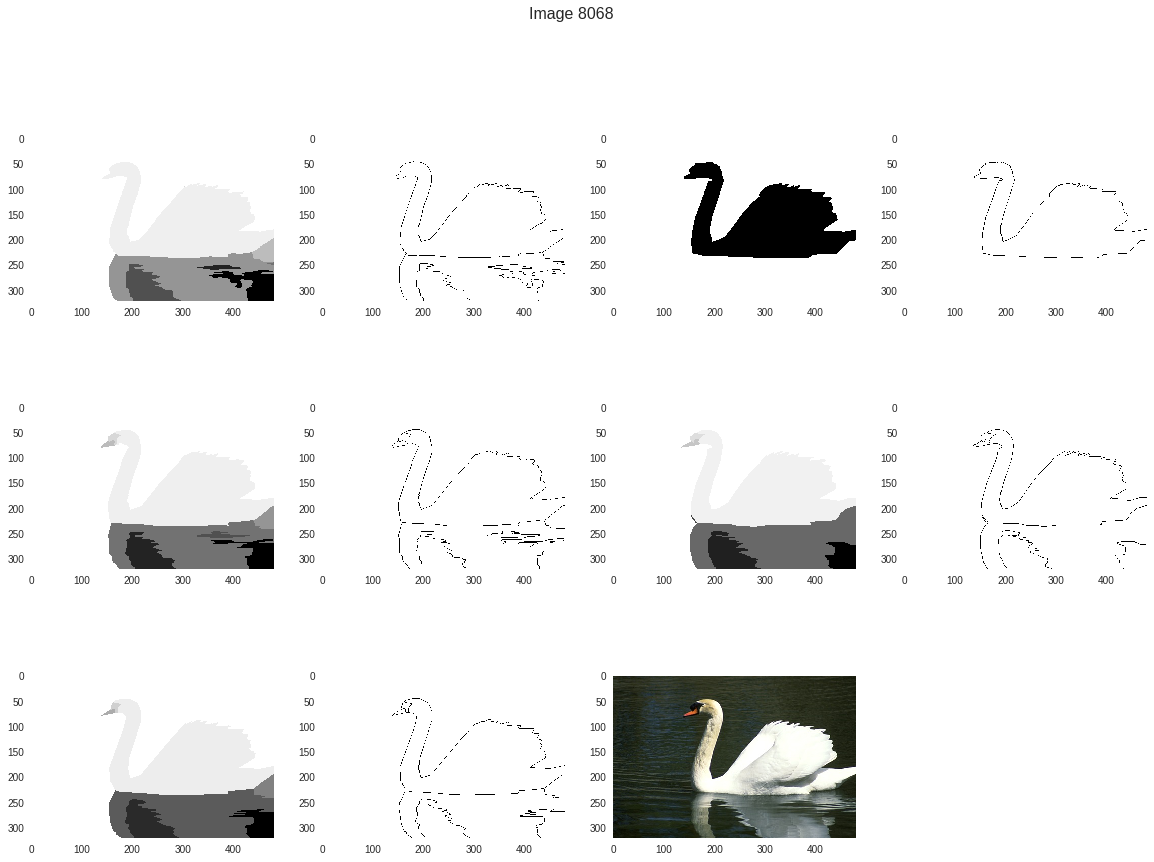

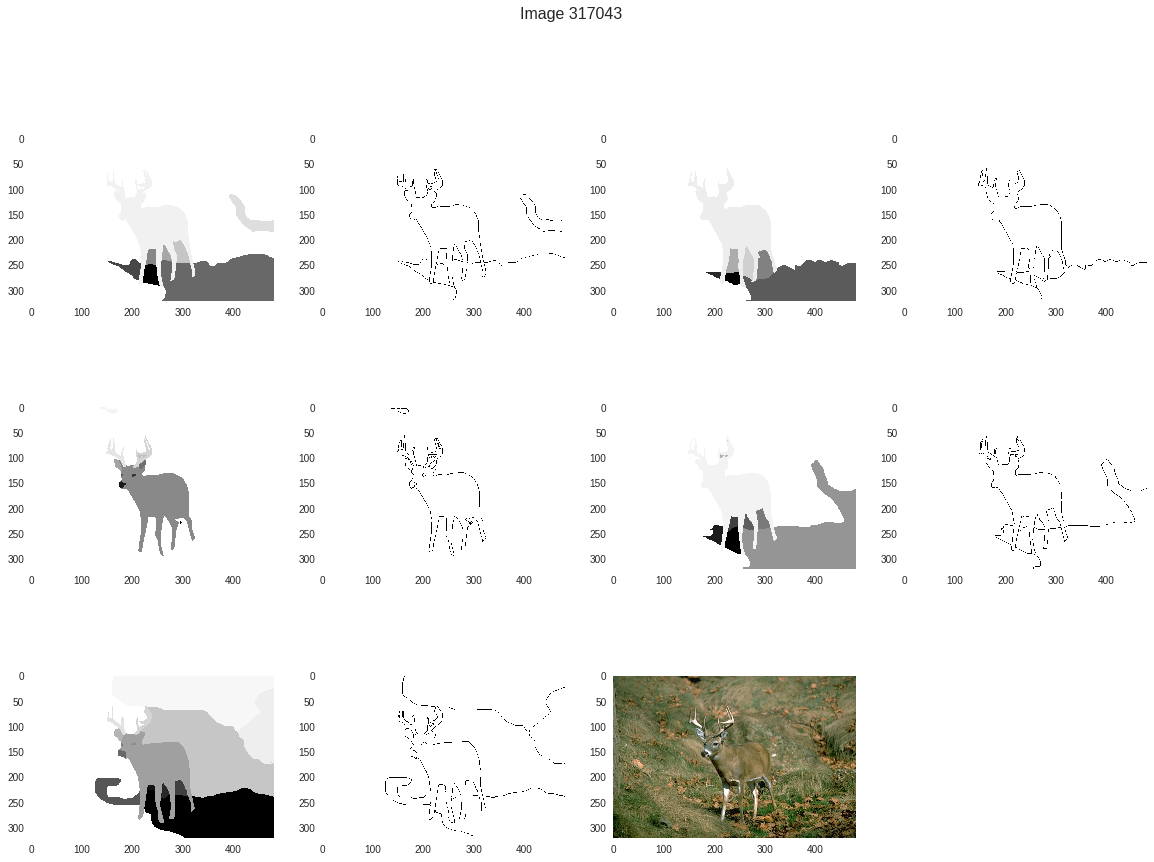

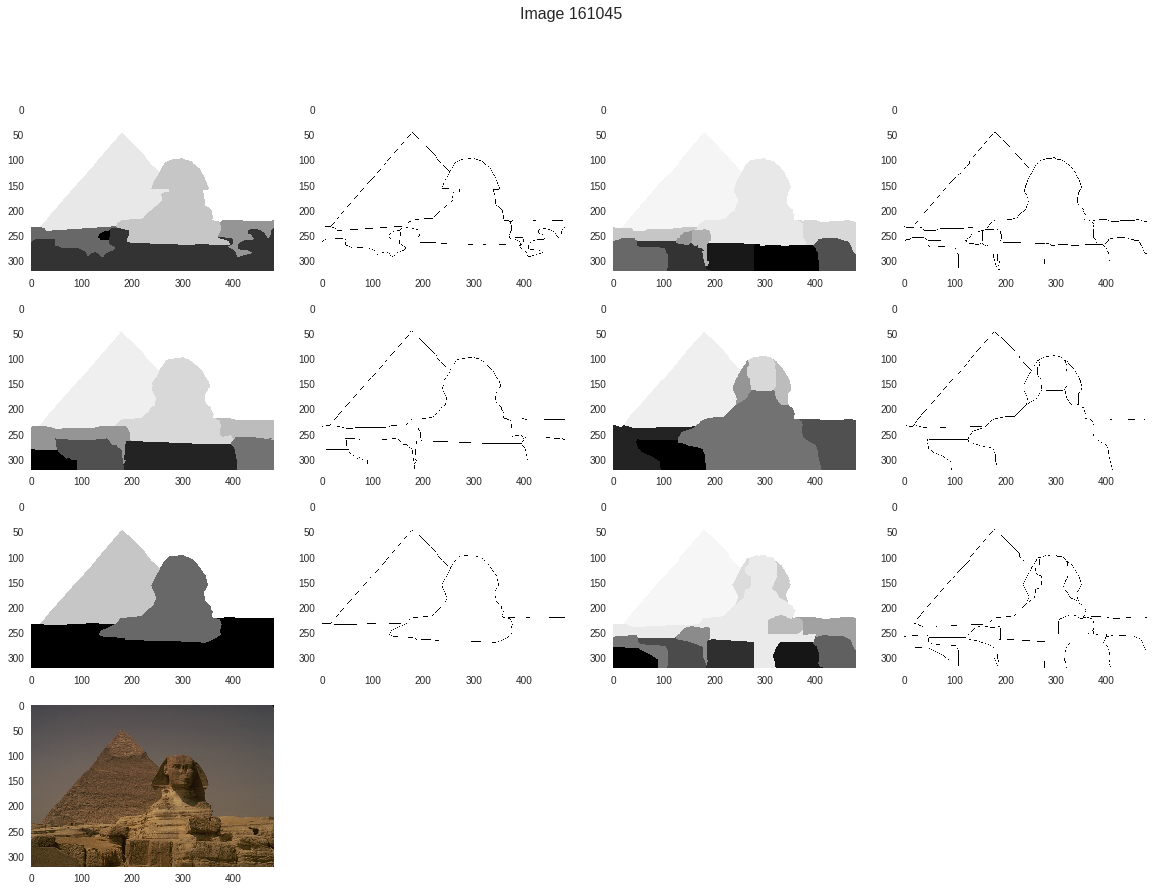

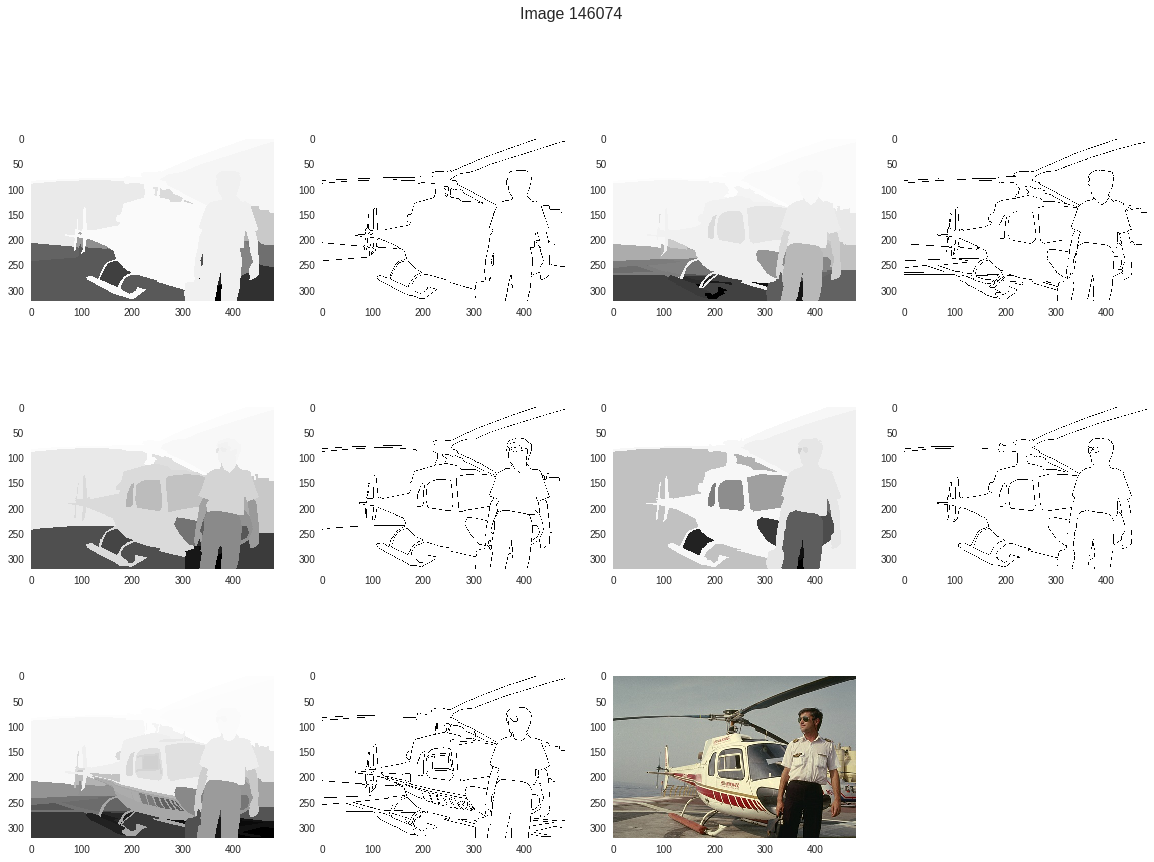

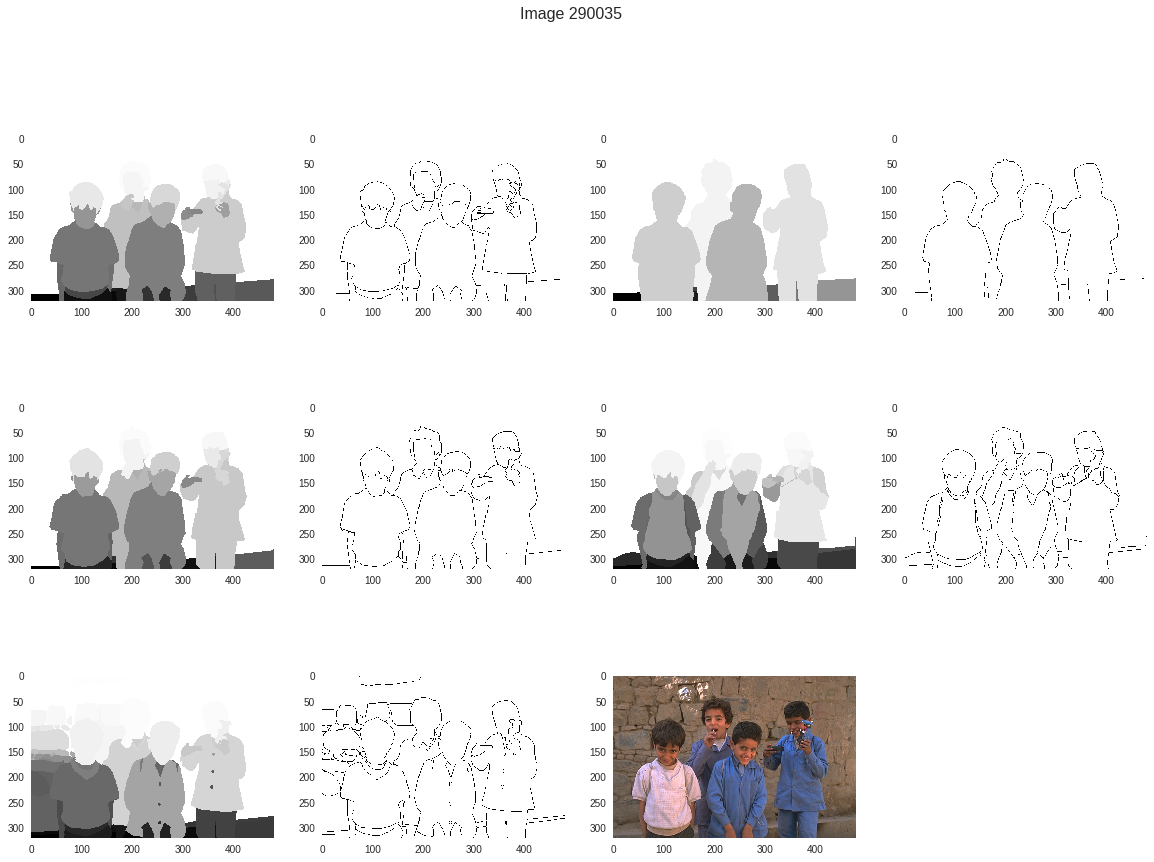

In [9]:
# random 5 images
indices = choice(list(range(50)), size=5)
for idx in indices:
    image = test_images[idx]
    gt = test_gt[idx]
    
    plt.figure(figsize=(20,14))
    plt.suptitle('Image %s' % image.id, fontsize=16)
    gts = len(gt)
    for i in range(gts):
        ax = plt.subplot((gts)//2+1,4,2*i+1)
        ax.grid(False)
        ax.imshow(gt[i][0].pixels)
        ax = plt.subplot((gts)//2+1,4,2*i+2)
        ax.grid(False)
        ax.imshow(gt[i][1].pixels)

    ax = plt.subplot((gts)//2+1,4,gts*2+1)
    ax.grid(False)
    ax.imshow(image.pixels)

    plt.show()

In [0]:
# function used to flatten the rows and cols of an imagae with the same number of channels
def reshape_dims(images):
    rows = images[0].shape[0] * images[0].shape[1]
    cols = images[0].shape[2]
    new_dim_images = []
    for image in images :
        new_dim_images.append( np.reshape(image.pixels, (rows, cols)) )
    
    return new_dim_images

## K-Means implementation (not currently used)

In [0]:
def k_means(data, k, distance, max_iterations=500, plot=False):
    """
    :param data: is the unsupervised data set
    :param k: the numbers of clusters that we want
    :param distance: the distance we want to take as a measure
    :param max_iterations: limit for the number of iterations
    :return: array like telling the cluster of each point
    """
    if plot:
        # to plot the the data after clustring
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('X3')

    temp = np.ones(data.shape[0]) * -1
    sample_idx_list = np.empty(data.shape[0])
    centroids = np.random.randint(255, size=(k, data.shape[1]))

    while max_iterations:

        print('In Cluster Assigning...')

        # assign to clusters part
        for sample_idx, sample in enumerate(data):

            minimum_dist = sys.maxsize

            for centroid_idx, centroid in enumerate(centroids):
                dist = distance(centroid, sample)
                if dist < minimum_dist:
                    minimum_dist = dist
                    sample_idx_list[sample_idx] = centroid_idx

        if np.array_equal(temp, sample_idx_list):  # stopping criteria if no change in clusters
            print("Clusters didn't change, no need for another loop")
            if plot:
                ax.scatter(centroids[0], centroids[1], centroids[2], c='gold', marker="x")
                plot_list = []  # used for plotting
                for idx, c in zip(range(k), ['maroon', 'red', 'pink', 'brown', 'orange', 'olive', 'yellow', 'green', 'blue', 'magenta', 'black']):
                    plot_list.append(ax.scatter(data[sample_idx_list == idx, 0], data[sample_idx_list == idx, 1],
                                                data[sample_idx_list == idx, 2], c=c))
            
            return sample_idx_list
                
        else:
            print("Clusters changed, another loop is needed")
            temp = sample_idx_list

        # update centroids part
        print('Updating centroids...')
        for idx in range(k):
            centroids[idx] = np.mean(data[sample_idx_list == idx], axis=0, keepdims=True) if data[
                sample_idx_list == idx].size else centroids[idx]
            
        max_iterations = max_iterations - 1
    return sample_idx_list

## K-Means clustering on training data

In [0]:
new_dim_images = np.asarray(reshape_dims(train_images))
diff_k_clustering = []
for k in [3, 5, 7, 9, 11]:
    images_cluster_index = []
    for idx, image in enumerate(new_dim_images):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(image)
        images_cluster_index.append(kmeans.labels_)
        print('image number ',idx, 'clustered using k = ', k)
    print('Done clustering with k = ', k)
    diff_k_clustering.append(images_cluster_index)

## Estimating K using elbow curve

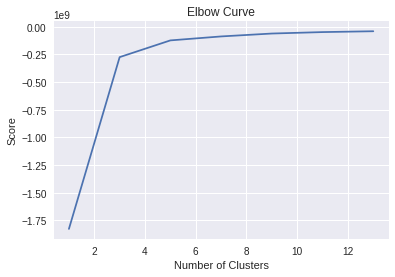

In [14]:
Nc = range(1, 15, 2)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(new_dim_images[10]).score(new_dim_images[10]) for i in range(len(kmeans))]
score

plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

## Spectral Clustering Implementation

In [0]:
def normalized_cut(X, k):
    sim_mat = kneighbors_graph(flattened_image, n_neighbors=6)
    # to make the similarity matrix symmetric. we take the
    # average between A and transpose(A)
    sim_mat = (sim_mat + sim_mat.T)/2

    return sparse_spectral_clustering(sim_mat, k, affinity=True)

In [0]:
def sparse_spectral_clustering(X, k, affinity=False):
    if not affinity:
        # compute similarity matrix
        A = np.array(rbf_kernel(X, X, gamma=1.0))
    else:
        A = X
    diag = [np.sum(A[i]) for i in range(A.shape[0])]
    delta = diags([diag], [0])
    L = delta - A
        
    delta_sqrt = diags([[1.0/sqrt(x) if x!= 0 else 1000000 for x in diag]], [0])
    Ls = delta_sqrt.dot(L).dot(delta_sqrt)
    n = A.shape[1]
    print("calculated laplacian matrix, now solving for eigenvalues and vectors")
    try:
        evalues, evectors = eigsh(Ls, k=k, which='SA', sigma=0.01)
    except ArpackNoConvergence as e:
        print(e)
        evalues = e.eigenvalues
        evectors = e.eigenvectors
        found = len(evalues)
    # evalues, evectors = eig(Ls)
    U = np.vstack(evectors)
    U = np.array([row/norm(row) for row in U])
    kmeans = KMeans(n_clusters=k).fit(U)
    return kmeans.labels_

## Effect of number of clusters on F1 score

To study the effect of the number of clusters on the score, we cluster a sample image into k clusters for values of k = {3,5,7,9,11} and for each one of them we compare it with its M ground truth. For each ground truth, we plot the relation between the number of clusters and the F1 score.

In [0]:
# pick a random test image
rand = np.random.choice(list(range(50)))

<function matplotlib.pyplot.show>

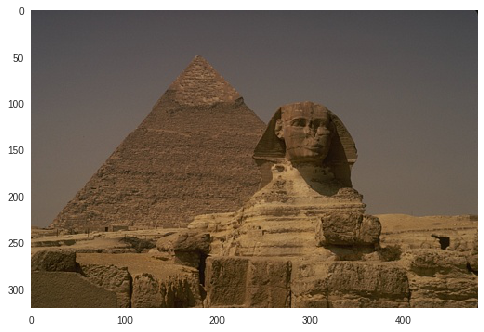

In [37]:
image = test_images[rand].pixels
shape = image.shape
flattened_image = image.reshape(shape[0]*shape[1], shape[2])
spatial_shape = test_spatial
flattened_spatial_image = test_spatial_images[rand].pixels.reshape()
gt = test_gt[rand]

plt.grid(False)
plt.imshow(image)
plt.show

In [74]:
Ks = list(range(3,12,2))
kmeans_segmentations = [KMeans(n_clusters=k, random_state=0).fit(flattened_image).labels_ for k in Ks]
sc_segmentations = [normalized_cut(flattened_image, k) for k in Ks]
sc_spectral_segmentations = [normalized_cut(flattened_image, k) for k in Ks]

calculated laplacian matrix, now solving for eigenvalues and vectors
calculated laplacian matrix, now solving for eigenvalues and vectors
calculated laplacian matrix, now solving for eigenvalues and vectors
calculated laplacian matrix, now solving for eigenvalues and vectors
calculated laplacian matrix, now solving for eigenvalues and vectors


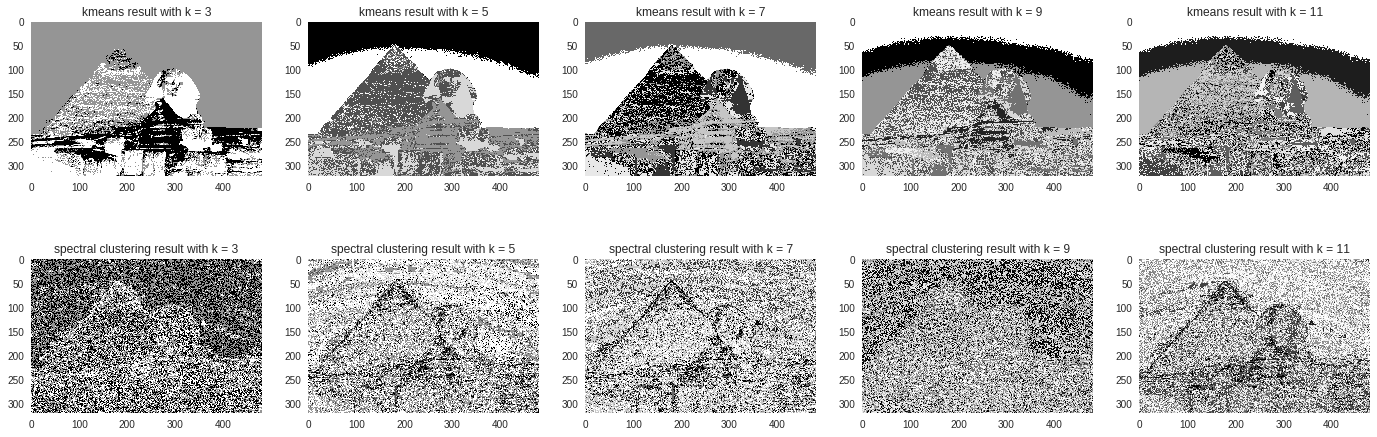

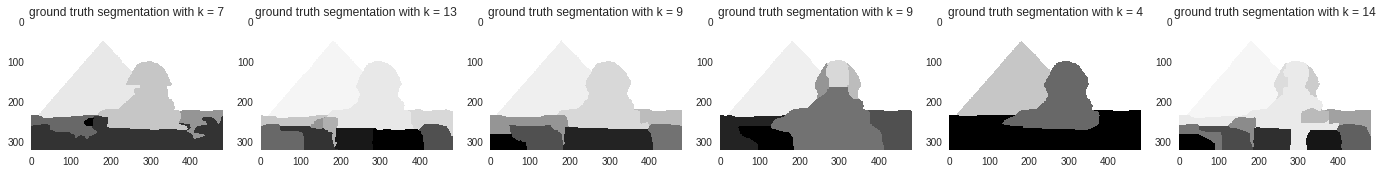

In [100]:
plt.figure(figsize=(24,8))
for i,(k, kmeans, spectral) in enumerate(zip(Ks, kmeans_segmentations, sc_segmentations)):
    plt.subplot(2,len(Ks), i+1)
    plt.grid(False)
    plt.title('kmeans result with k = {}'.format(k))
    plt.imshow(kmeans.reshape(shape[0:2]))
    plt.subplot(2,len(Ks), len(Ks)+i+1)
    plt.grid(False)
    plt.title('spectral clustering result with k = {}'.format(k))
    plt.imshow(spectral.reshape(shape[0:2]))
plt.show()

plt.figure(figsize=(24,4))
for i,truth in enumerate(gt):
    plt.subplot(1,len(gt), i+1)
    plt.grid(False)
    k_of_gt = len(np.unique(truth[0].pixels))
    plt.title('ground truth segmentation with k = {}'.format(k_of_gt))
    plt.imshow(truth[0].pixels)
plt.show()

In [0]:
legend = []
f1_scores = []
f1_kmeans_scores = []
for i,truth in enumerate(gt):
    scores = []
    kmeans_scores = []
    for segments, kmeans_segments in zip(sc_segmentations, kmeans_segmentations):
        scores.append(f1_score(truth[0].pixels.reshape(321*481), segments, average='macro'))
        kmeans_scores.append(f1_score(truth[0].pixels.reshape(321*481), kmeans_segments, average='macro'))
    f1_scores.append(scores)
    f1_kmeans_scores.append(kmeans_scores)
    k_of_gt = len(np.unique(truth[0].pixels))
    legend.append('ground truth {} with k = {}'.format(i+1, k_of_gt))


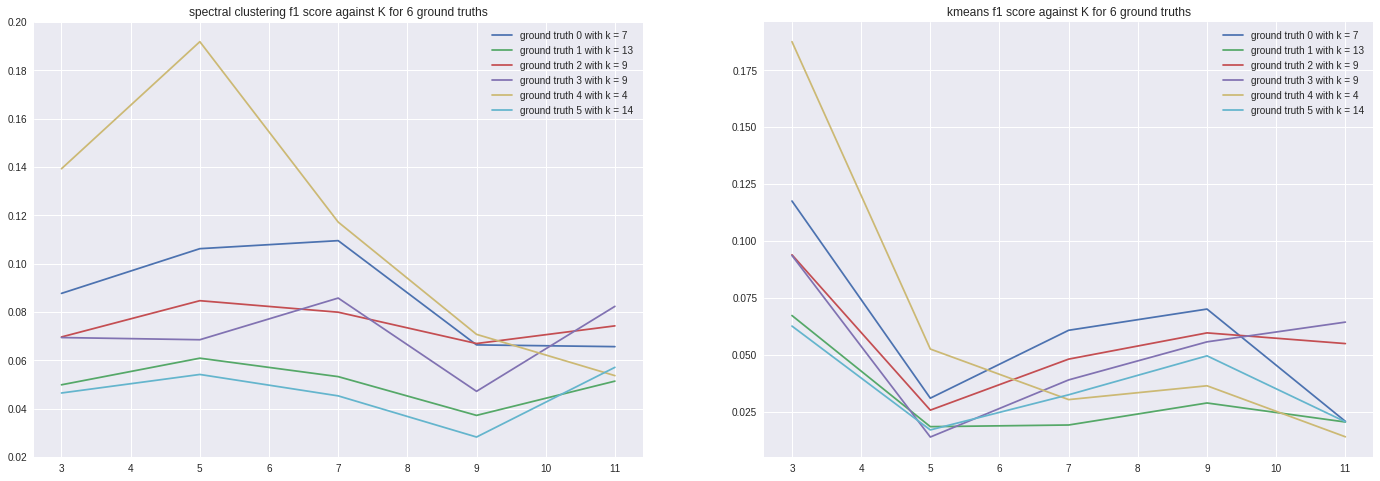

In [103]:
plt.figure(figsize=(24,8))
plt.subplot(1,2,1)
for score in f1_scores:
    plt.plot(Ks, score)
    plt.legend(legend)
    plt.title('spectral clustering f1 score against K for {} different ground truths'.format(len(f1_scores)))

plt.subplot(1,2,2)
for score in f1_kmeans_scores:
    plt.plot(Ks, score)
    plt.legend(legend)
    plt.title('kmeans f1 score against K for {} different ground truths'.format(len(f1_scores)))

plt.show()

## Evaluating on test data

### Results on random 5 images
here are the results of clustering with K = 5 using kmeans and spectral clustering on the raw image and the image with spatial layout encoded.

calculated laplacian matrix, now solving for eigenvalues and vectors
calculated laplacian matrix, now solving for eigenvalues and vectors


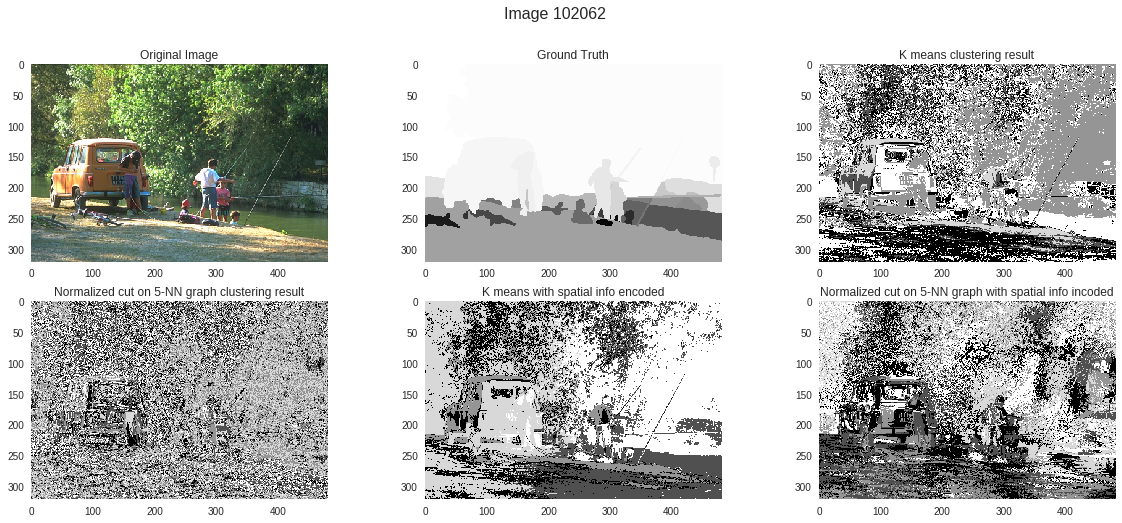

calculated laplacian matrix, now solving for eigenvalues and vectors
calculated laplacian matrix, now solving for eigenvalues and vectors


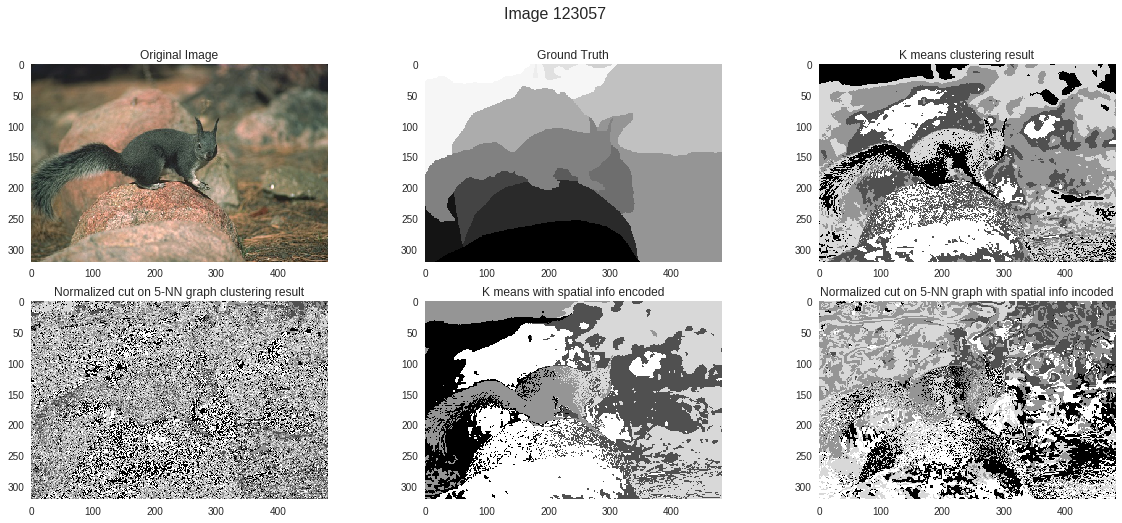

calculated laplacian matrix, now solving for eigenvalues and vectors
calculated laplacian matrix, now solving for eigenvalues and vectors


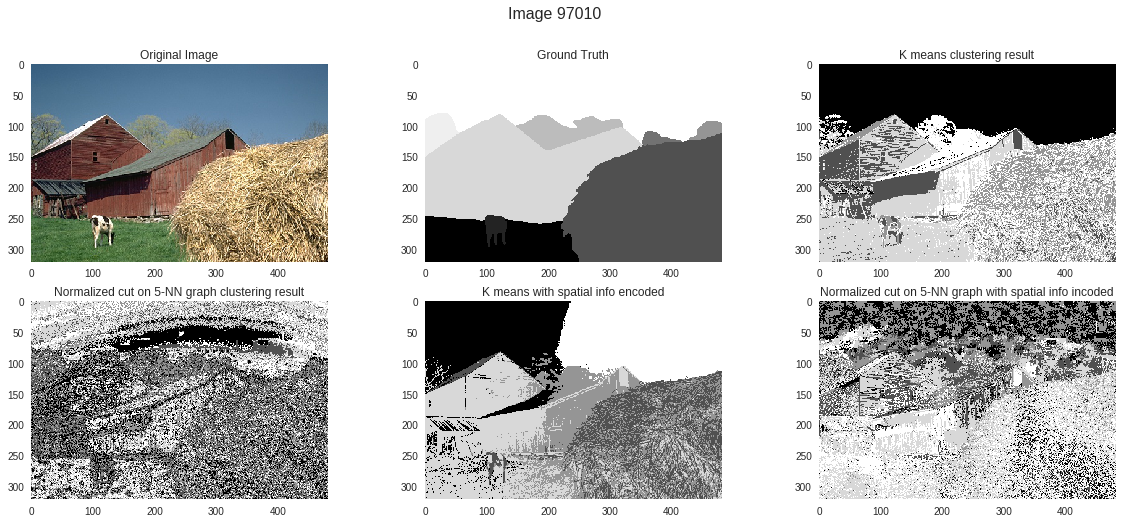

calculated laplacian matrix, now solving for eigenvalues and vectors
calculated laplacian matrix, now solving for eigenvalues and vectors


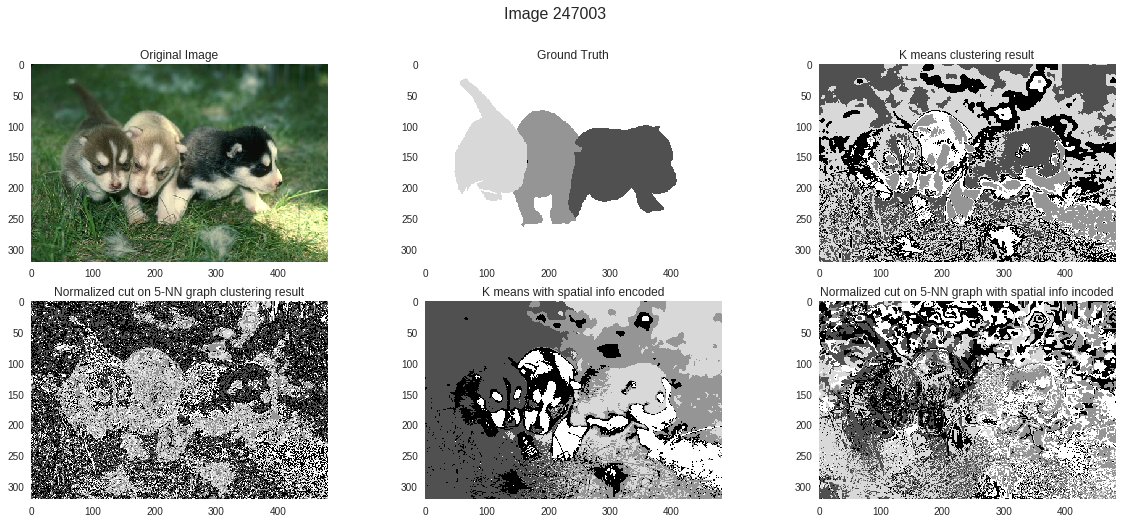

calculated laplacian matrix, now solving for eigenvalues and vectors
calculated laplacian matrix, now solving for eigenvalues and vectors


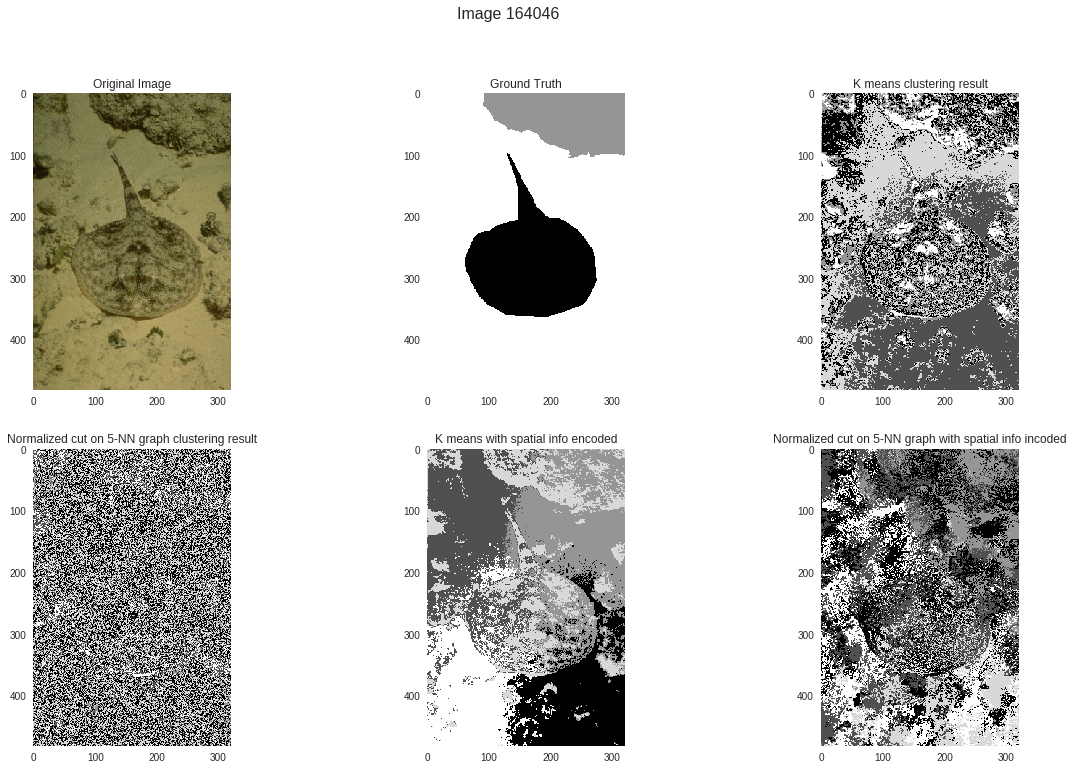

In [128]:
indices = choice(list(range(50)), size=5, replace=False)

for idx in indices:
    image = test_images[idx]
    spatial_image = test_spatial_images[idx]
    gt = test_gt[idx]
    shape = image.shape
    spatial_shape = spatial_image.shape
    
    if(shape[0] > shape[1]):
        plt.figure(figsize=(20,12))
    else:
        plt.figure(figsize=(20,8))
    
    plt.suptitle('Image %s' % image.id, fontsize=16)
    
    ax = plt.subplot(2,3,1)
    plt.title('Original Image')
    ax.grid(False)
    ax.imshow(image.pixels)
    
    ax = plt.subplot(2,3,2)
    plt.title('Ground Truth')
    ax.grid(False)
    ax.imshow(gt[0][0].pixels)
    
    flattened_image = image.pixels.reshape((shape[0]*shape[1], shape[2]))
    
    kmeans = KMeans(n_clusters=5, random_state=0).fit(flattened_image)
    labels = kmeans.labels_
    ax = plt.subplot(2,3,3)
    plt.title('K means clustering result')
    ax.grid(False)
    ax.imshow(labels.reshape(shape[0:2]))
    
    segments = normalized_cut(flattened_image, 5)
    ax = plt.subplot(2,3,4)
    ax.grid(False)
    plt.title('Normalized cut on 5-NN graph clustering result')
    ax.imshow(segments.reshape(shape[0:2]))
    
    flattened_image = spatial_image.pixels.reshape((shape[0]*shape[1], spatial_shape[2]))

    kmeans = KMeans(n_clusters=5, random_state=0).fit(flattened_image)
    labels = kmeans.labels_
    ax = plt.subplot(2,3,5)
    plt.title('K means with spatial info encoded')
    ax.grid(False)
    ax.imshow(labels.reshape(shape[0:2]))
    
    segments = normalized_cut(flattened_image, 5)
    ax = plt.subplot(2,3,6)
    ax.grid(False)
    plt.title('Normalized cut on 5-NN graph with spatial info incoded')
    ax.imshow(segments.reshape(shape[0:2]))
    plt.show()
    

In [0]:
def evaluate(true_labels, perdicted_labels):
    # code for conditional entropy here
    return 0

def avg(vals):
    return sum(vals)*1.0/len(vals)

### Evaluating on the full test set (50 images)

In [0]:
# calculate F1 score for each image by averaging the F1 score for each available ground truth.
# The F1 score for an algorithm is the average across all images.

# should also calculate the conditional entropy (will need to build the contengincy table for each image)
# calculate the conditional entropy in a separate function
# see sklearn.metrics.v_measure_score for something similar to conditional entropy

for i,(image, gts) in enumerate(zip(test_images[0:50], test_gt[0:50])):
    shape = image.shape
    flattened_image = image.pixels.reshape(shape[0]*shape[1], shape[2])
    labels = normalized_cut(flattened_image, 5)
    scores = [f1_score(gt[0].pixels.reshape(shape[0]*shape[1]), labels, average='macro') for gt in gts]
    print('image %d average f1 score: %.3f, max f1 score: %.3f'% (image.id, avg(scores), max(scores)))
    

calculated laplacian matrix, now solving for eigenvalues and vectors
image 0 average f1 score: 0.011, max f1 score: 0.016
calculated laplacian matrix, now solving for eigenvalues and vectors
image 1 average f1 score: 0.092, max f1 score: 0.143
calculated laplacian matrix, now solving for eigenvalues and vectors
image 2 average f1 score: 0.020, max f1 score: 0.072
calculated laplacian matrix, now solving for eigenvalues and vectors
image 3 average f1 score: 0.073, max f1 score: 0.122
calculated laplacian matrix, now solving for eigenvalues and vectors
image 4 average f1 score: 0.046, max f1 score: 0.108
calculated laplacian matrix, now solving for eigenvalues and vectors
image 5 average f1 score: 0.019, max f1 score: 0.041
calculated laplacian matrix, now solving for eigenvalues and vectors
image 6 average f1 score: 0.063, max f1 score: 0.122
calculated laplacian matrix, now solving for eigenvalues and vectors
image 7 average f1 score: 0.048, max f1 score: 0.068
calculated laplacian mat

In [0]:
kmeans_avg_scores = []
for image, gts in zip(test_images[0:50], test_gt[0:50]):
    shape = image.shape
    flattened_image = image.pixels.reshape(shape[0]*shape[1], shape[2])
    kmeans = KMeans(n_clusters=5, random_state=0).fit(flattened_image)
    labels = kmeans.labels_
    scores = [f1_score(gt[0].pixels.reshape(shape[0]*shape[1]), labels, average='macro') for gt in gts]
    avg = np.average(scores)
    kmeans_avg_scores.append(scores)
    print('image %d average f1 score: %.3f, max f1 score: %.3f'% (image.id, avg, max(scores)))